In [17]:
# ライブラリのimport
import numpy as np
import pandas as pd
# 表示桁数の指定
%precision 3
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# グラフをjupyter notebook内に表示
%matplotlib inline
# ライブラリのimport
import scipy as sp
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 表示桁数の指定
%precision 3

'%.3f'

In [18]:
sales = pd.read_csv("5-3-1-lm-model.csv")
sales.head()

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy
3,39.7,290,195.5,23.0,rainy
4,24.7,290,214.4,14.5,rainy


In [19]:
len(sales)

100

### <font color='blue'>データの図示</font>

まずはデータの図示<br>

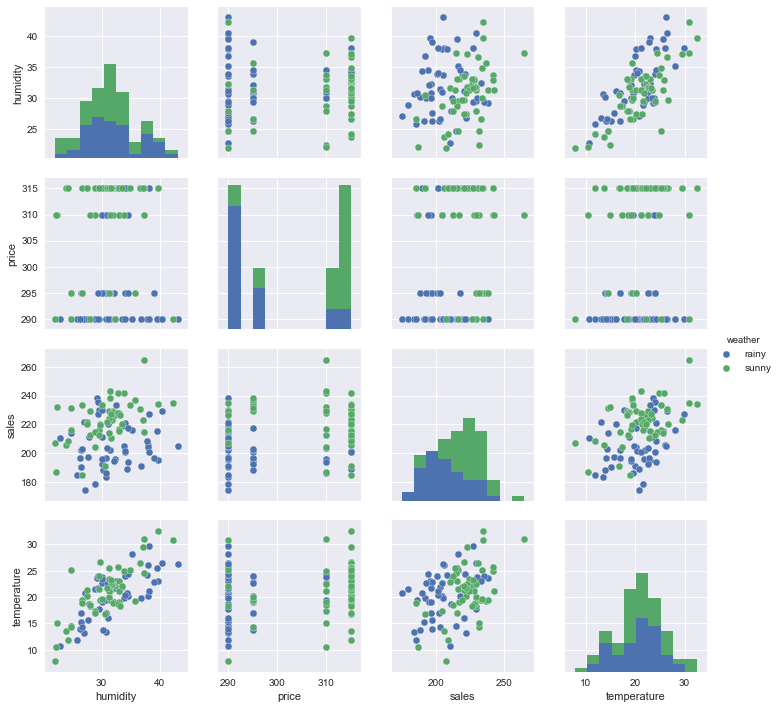

In [20]:
sns.pairplot(sales, hue='weather')

気温が高くなると湿度も高くなっていることがわかる。<br>

### <font color='blue'>悪い分析例：変数が１つだけのモデルを作成</font>

In [21]:
# 説明変数に価格だけを用いて、単回帰モデルを推定
lm_dame = smf.ols("sales ~ price", sales).fit()

In [22]:
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

In [23]:
# 分散分析
sm.stats.anova_lm(lm_dame, typ=2)

,sum_sq,df,F,PR(>F)
price,1398.392322,1.0,4.970685,0.028064
Residual,27570.133578,98.0,NaN,NaN


上記の結果から、価格は売上に対して有意な影響を持っており<br>
価格が上がると売上も増えるということ。<br>

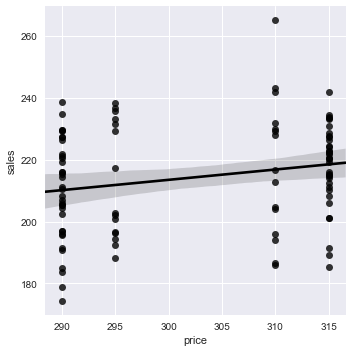

In [24]:
# 回帰直線
# 網掛け部分は回帰直線の95%信頼区間を表している。
sns.lmplot(x = "price", y = "sales", data = sales, scatter_kws = {"color":"black"}, line_kws = {"color":"black"})

### <font color='blue'>説明変数同士の関係を調べる</font>

In [25]:
sales.groupby("weather").mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


上記を見ると売上は雨の日に下がっていることがわかる。<br>
また、雨の日の方が低い価格に設定されている。<br>
「雨の日には売上が下がるので、その対策としてお店が値引きをしていた。」と考える。<br>

では、「天気が同じだった時の、商品価格が売上にもたらす影響」は何か？<br>

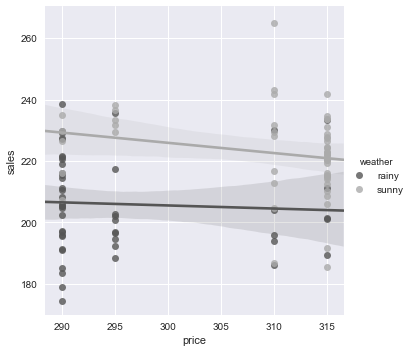

In [26]:
sns.lmplot(x='price', y='sales', data=sales, hue= 'weather', palette='gray')

天気別で見ると「価格が高くなると、売上が下がる」ということがわかる。<br>

晴れと雨で分けると「検定の２重性」が発生することに注意。<br>

## 複数の説明変数を持つモデル

説明変数が４つ全て入ったモデル。<br>

In [27]:
# 複数の説明変数を持つモデルを推定する
lm_sales = smf.ols("sales ~ weather + humidity + temperature + price", data = sales).fit()

In [28]:
# 推定された結果
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

<font color='red'>注目すべきなのは価格の係数がマイナスになっていること</font>

### 悪い分析例:通常の分散分析で検定する

In [46]:
sm.stats.anova_lm(lm_sales, typ=1).round(3)

/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
humidity,1.0,1779.601,1779.601,9.805,0.002
temperature,1.0,2076.845,2076.845,11.443,0.001
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


上記の検定結果は誤りである。<br>
Type I ANOVAは、説明変数を入れる順番を変えると検定の結果が変わる。<br>

In [30]:
# 説明変数の順番を変える
lm_sales2 = smf.ols("sales ~ weather + temperature + humidity + price", data=sales).fit()

In [31]:
sm.stats.anova_lm(lm_sales2, typ=1).round(3)

/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
temperature,1.0,3814.779,3814.779,21.018,0.000
humidity,1.0,41.667,41.667,0.230,0.633
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


順番を変えると、湿度のp値が0.5以上となり売上に有意な影響を与えないことになった。<br>

### 回帰係数のt検定

In [17]:
lm_sales.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     16.15
Date:                Sat, 16 Jun 2018   Prob (F-statistic):           4.01e-10
Time:                        14:55:43   Log-Likelihood:                -399.39
No. Observations:                 100   AIC:                             808.8
Df Residuals:                      95   BIC:                             821.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          278.6277     46.335      6.013      0.000     186.641     370.615
weather[T.sunny]    19.9891      3.522      5.675      0.000      12.997      26.982
humidity            -0.2541      0.456     -0.558      0.578      -1.159       0.651
temperature          1.6031      0.443      3.620      0.000       0.724       2.482
price               -0.3292      0.155     -2.123      0.036      -0.637      -0.021
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.016
Skew:                          -0.028   Prob(JB):                        0.992
Kurtosis:                       3.027   Cond. No.                     1.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [18]:
lm_sales2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


変数の順番を入れ替えたが、湿度の回帰係数のp値は共に0.578となっている。<br>
つまり、回帰係数のt検定ならば説明変数の順番がもたらす問題は発生しないことが分かる。<br>

### Type II ANOVA

説明変数を入れる順番を変えても検定の結果が変わらない分散分析<br>
をType II ANOVAという。<br>

### モデル選択と分散分析

「Type I ANOVA」の計算方法について説明する。<br>

In [32]:
# NULLモデルの残差平方和
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = sp.sum(mod_null.resid ** 2)
resid_sq_null

28968.526

In [33]:
# 天気モデルの残差平方和
mod_1 = smf.ols("sales ~ weather", sales).fit()
resid_sq_1 = sp.sum(mod_1.resid ** 2)
resid_sq_1

21917.565

In [34]:
# 残差平方和の差
resid_sq_null - resid_sq_1

7050.961

In [35]:
sm.stats.anova_lm(mod_1).round(3)

/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,31.527,0.0
Residual,98.0,21917.565,223.649,NaN,NaN


モデルに「天気」という説明変数を加えることによって減少する残差平方和<br>

In [36]:
# humidityを追加
mod_2 = smf.ols("sales ~ weather + humidity", sales).fit()
resid_sq_2 = sp.sum(mod_2.resid ** 2)
resid_sq_2

20137.964

「天気」だけのモデルから「天気 + 湿度」のモデルの残差平方和をひく。

In [37]:
resid_sq_1 - resid_sq_2

1779.601

残差平方和の差は、分散分析表にも現れる。<br>

In [38]:
sm.stats.anova_lm(mod_2).round(3)

/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,33.963,0.000
humidity,1.0,1779.601,1779.601,8.572,0.004
Residual,97.0,20137.964,207.608,NaN,NaN


分散分析は、説明変数を１つずつ増やしていき、「説明変数が増えることによって減少する残差平方和の大きさ」<br>
に基づいて「説明変数の持つ効果の大きさ」を定量化している。<br>

この方法だと、説明変数を増やしていく順番が大きな意味を持ってしまう。<br>

In [41]:
# 天気+気温モデルの残差平方和
mod_2_2 = smf.ols("sales ~ weather + temperature", data =sales).fit()
resid_sq_2_2 = sp.sum(mod_2_2.resid ** 2)
resid_sq_2_2

18102.786

In [43]:
# 天気+気温+湿度
mod_3_2 = smf.ols("sales ~ weather + temperature + humidity", data =sales).fit()
resid_sq_3_2 = sp.sum(mod_3_2.resid ** 2)
resid_sq_3_2

18061.119

In [44]:
resid_sq_2_2 - resid_sq_3_2

41.667

In [45]:
sm.stats.anova_lm(mod_3_2).round(3)

/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Takanori/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
temperature,1.0,3814.779,3814.779,20.277,0.000
humidity,1.0,41.667,41.667,0.221,0.639
Residual,96.0,18061.119,188.137,NaN,NaN


### Type II ANOVAと調整平方和